New Paths:  ['D:/esophagous-cancer-images\\Endoscopy-esophagus', 'D:/esophagous-cancer-images\\Esophagous-cancer-detection-testing-image', 'D:/esophagous-cancer-images\\IC-EC project.ipynb', 'D:/esophagous-cancer-images\\model']
Images Count:  10662


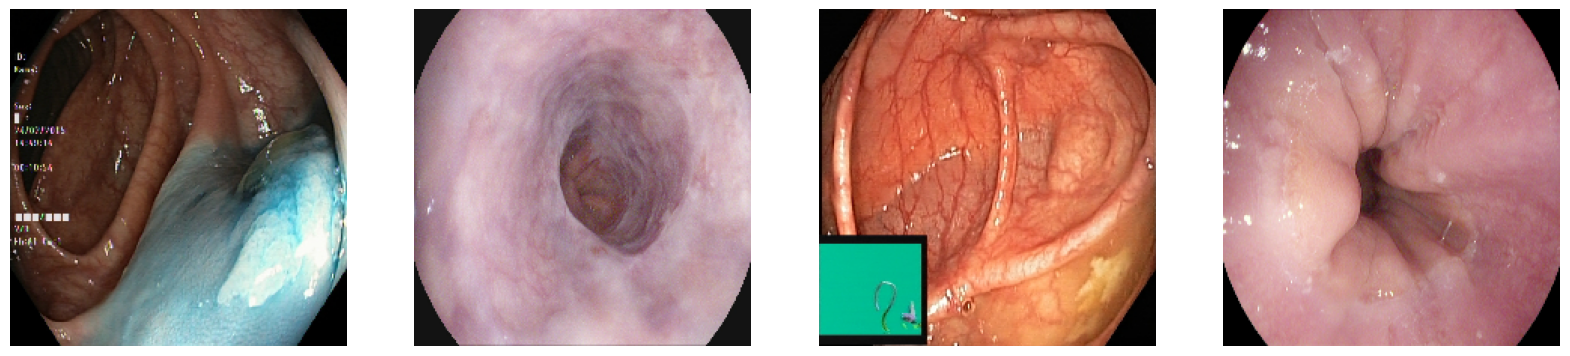

473176280/473176280 ━━━━━━━━━━━━━━━━━━━━ 39s 0us/step 
Found 8531 images belonging to 2 classes.
Found 2131 images belonging to 2 classes.
Epoch 1/3
267/267 ━━━━━━━━━━━━━━━━━━━━ 2264s 8s/step - accuracy: 0.9760 - loss: 0.0585 - val_accuracy: 0.9897 - val_loss: 0.0325
Epoch 2/3
267/267 ━━━━━━━━━━━━━━━━━━━━ 2053s 8s/step - accuracy: 0.9898 - loss: 0.0262 - val_accuracy: 0.9930 - val_loss: 0.0231
Epoch 3/3
267/267 ━━━━━━━━━━━━━━━━━━━━ 2334s 9s/step - accuracy: 0.9947 - loss: 0.0145 - val_accuracy: 0.9911 - val_loss: 0.0257


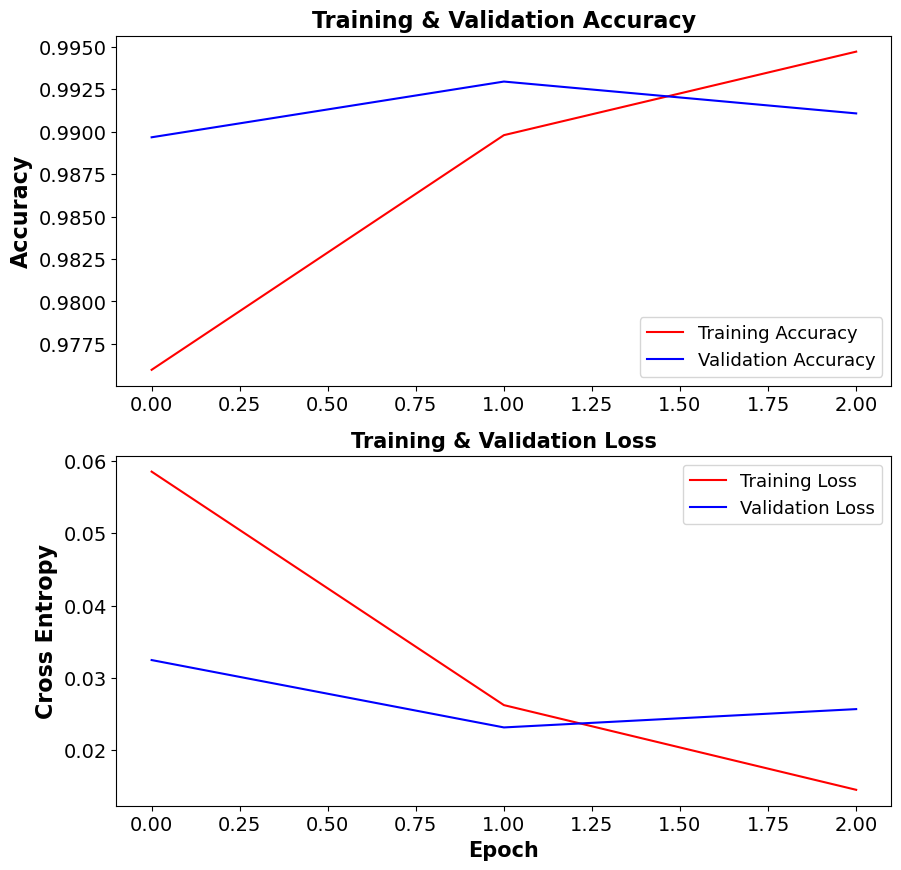

In [12]:
# ===================================================================================================================================================== #
#                                     "DEEP LEARNING-BASED ESOPHAGEAL CANCER RISK PREDICTION FROM ENDOSCOPY IMAGES"                                     #
# ===================================================================================================================================================== #
# This code trains a deep learning model to detect esophageal cancer from endoscopy images
# using transfer learning with EfficientNetV2L as the base model.
# The model processes images at 224x224 resolution and outputs a binary classification.

import itertools
import cv2
import os
import time

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

# EfficientNetV2L - chosen for high accuracy while maintaining reasonable computation requirements

from tensorflow.keras.applications import EfficientNetV2L as PretrainedModel
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input  # Preprocessing specific to EfficientNetV2
from tensorflow.keras.layers import Input, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For data augmentation and batch processing
from tensorflow.keras.callbacks import EarlyStopping

# For model evaluation metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# For file path management
from glob import glob

# =======================================================================================================================
#                                              DATA PREPARATION AND EXPLORATION
# =======================================================================================================================

# Get the paths to the main directories
# Replace path which points to main directories
folders = glob('D:/esophagous-cancer-images' + '/*')
print('New Paths: ', folders)

# Count the total number of images in the dataset
IMAGE_FILES = glob('D:/esophagous-cancer-images/Endoscopy-esophagus' + '/*/*.*')
print('Images Count: ', len(IMAGE_FILES))

# Select sample images for visualization (2 positive and 2 negative examples)
# Replace path which point to 2 esophagus and 2 non-esophagus files
SAMPLES = [
    "D:/esophagous-cancer-images/Endoscopy-esophagus/no-esophagus/00a2c35e-97d1-4056-89a5-bc904ff96371.jpg",  
    "D:/esophagous-cancer-images/Endoscopy-esophagus/esophagus/0c61343a-52a3-4f9b-85c3-732637968885.jpg",     
    "D:/esophagous-cancer-images/Endoscopy-esophagus/no-esophagus/0a4c2cc2-a86f-4cac-84ca-942b17a6e6db.jpg",  
    "D:/esophagous-cancer-images/Endoscopy-esophagus/esophagus/1e78f2df-fffb-4546-9dd0-9459e8da88e1.jpg"      
]

# Visualize sample images to understand the dataset
plt.figure(figsize=(20, 10))
for i, img_path in enumerate(SAMPLES):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input size
    plt.subplot(1, len(SAMPLES), i+1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

# =======================================================================================================================
#                                MODEL ARCHITECTURE - TRANSFER LEARNING WITH EFFICIENTNETV2L
# =======================================================================================================================
# Create a model using EfficientNetV2L pretrained on ImageNet as the base, with custom classification layers on top

# Load the pre-trained EfficientNetV2L model without the top classification layer
# input_shape=(224, 224, 3) specifies the image dimensions and RGB channels
base_model = PretrainedModel(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to a flat vector
x = Dense(1024, activation='relu')(x)  # Hidden layer with 1024 neurons and ReLU activation
predictions = Dense(1, activation='sigmoid')(x)  # Output layer with sigmoid for binary classification

# Construct the full model by connecting base model input to our custom layers
EsophagealCancer_Model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers to prevent them from being updated during initial training(preserves initial knowledge)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model with binary cross-entropy loss (suitable for binary classification) and Adam optimizer (efficient and commonly used for deep learning)
EsophagealCancer_Model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# ============================================================================================================================
#                                           DATA GENERATORS FOR TRAINING AND VALIDATION
# ============================================================================================================================

# validation_split=0.2 reserves 20% of data for validation
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=0.2)

# Training data generator
train_generator = train_datagen.flow_from_directory(
   'D:/esophagous-cancer-images/Endoscopy-esophagus',
    target_size=(224, 224),  # Resize images to match model input
    batch_size=32,  # Process 32 images at a time (adjust based on available memory)
    class_mode='binary',  # Binary classification (cancer/no-cancer)
    subset='training'  # Use the training portion of the dataset
)

# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    'D:/esophagous-cancer-images/Endoscopy-esophagus',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation'  # Use the validation portion of the dataset
)

# ======================================================================================================================
#                                                          MODEL TRAINING
# ======================================================================================================================

# Train the model for 3 epochs (complete passes through the dataset)
history = EsophagealCancer_Model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=3,  # Number of complete passes through the training data
    verbose=1,  # Show progress bar
)

# ======================================================================================================================
#                                                 VISUALIZATION OF TRAINING RESULTS
# ======================================================================================================================

# Extract metrics from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure with two subplots
plt.figure(figsize=(10, 10))

# Plot training and validation accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='r')
plt.plot(val_acc, label='Validation Accuracy', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='lower right', fontsize=13)
plt.ylabel('Accuracy', fontsize=16, weight='bold')
plt.title('Training & Validation Accuracy', fontsize=16, weight='bold')

# Plot training and validation loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='r')
plt.plot(val_loss, label='Validation Loss', color='b')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='upper right', fontsize=13)
plt.ylabel('Cross Entropy', fontsize=16, weight='bold')
plt.title('Training & Validation Loss', fontsize=15, weight='bold')
plt.xlabel('Epoch', fontsize=15, weight='bold')

# Display the plots
plt.show()

In [18]:
# Saving the model(.keras extension) in particular path
EsophagealCancer_Model.save('D:/esophagous-cancer-images/model/ICECmodel.keras')

In [38]:
# Install with: !pip install gradio
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input
import tensorflow as tf

print('* To create a public link, set \'share=True\' in launch().\n* To open prediction output in webpage, set \'quiet=False\' in launch().')
# Load the model
model = load_model('D:/esophagous-cancer-images/model/ICECmodel.keras')

def predict_cancer(image):
    if image is None:
        return None, ""
    
    # Preprocess exactly as during training to maintain accuracy
    img_array = np.array(image)
    img_resized = tf.image.resize(img_array, (224, 224))
    img_array = np.expand_dims(img_resized, 0)
    img_array = preprocess_input(img_array)
    
    # Make prediction
    prediction = model.predict(img_array)[0][0]
    
    # Interpret the result
    if prediction > 0.5:
        result = f"<span style='color:red; font-size:20px'>Esophageal Cancer Detected</span>"
        confidence = prediction
    else:
        result = f"<span style='color:green; font-size:20px'>No Esophageal Cancer Detected</span>"
        confidence = 1 - prediction
    
    return image, f"{result}<br><b>Confidence: {confidence:.2%}</b>"

# Create a clean Gradio interface focused on user uploads
with gr.Blocks(css="footer{display:none !important}") as demo:
    with gr.Column():
        gr.HTML("<h1 style='text-align:center; margin-bottom:10px'>Esophageal Cancer Prediction</h1>")
        gr.HTML("<p style='text-align:center'>Upload your endoscopy image</p>")
        
        with gr.Row():
            input_image = gr.Image(type="pil", label="")
            
        with gr.Column():
            submit_btn = gr.Button("Analyze Image", variant="primary")
            output_image = gr.Image(type="pil", label="")
            result_html = gr.HTML(label="")
        
        submit_btn.click(
            fn=predict_cancer,
            inputs=[input_image],
            outputs=[output_image, result_html]
        )

# Launch the interface
demo.launch(inline=True, share=False, quiet=True)

* To create a public link, set 'share=True' in launch().
* To open prediction output in webpage, set 'quiet=False' in launch().
